In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from matplotlib.pyplot import figure

In [14]:
def random_forest(df, drop_pairs=True):
    '''
    Finding the variable importances.
    Args:
        df (dataframe): The dataframe of the one-hot encoded dataset.
        drop_pairs (bool): True (default) - the importance of the reacting molecules/pairs 
                            are not shown in the variable importances.
    Returns:
        rf_importances (dataframe): All importances that are greater than 0.01.
    '''
    
    rf = RandomForestRegressor()
#     df = df.drop(['rxn_type'], axis=1)
    df = df.drop(['z_score'], axis=1)
    train, test = train_test_split(df, test_size=0.15, random_state=9)
    train_input = train.loc[:, train.columns != 'Product_Yield_PCT_Area_UV']
    train_labels = train['Product_Yield_PCT_Area_UV']
    test_input = test.loc[:, test.columns != 'Product_Yield_PCT_Area_UV']
    test_labels = test['Product_Yield_PCT_Area_UV']
    
    rf.fit(train_input, train_labels)
    pred = rf.predict(test_input)
    
    importances = rf.feature_importances_
    
    feature_names = train_input.columns
    rf_importances = pd.DataFrame({'importances' : importances, 'feat' : feature_names})
    rf_importances = rf_importances.loc[rf_importances['importances'] > 0.01]
    rf_importances = rf_importances.reset_index(drop=True)
    if drop_pairs == True:
        # Removing pairs:
        drop_idxs = []
        for i in range(len(rf_importances)):
            match = re.search('pair_', rf_importances.loc[i, 'feat'])
            if match is not None:
                drop_idxs.append(i)
        rf_importances = rf_importances.drop(drop_idxs)
        rf_importances = rf_importances.reset_index(drop=True)
    
    return rf_importances

def get_feats(rf_importances, feat_dict):
    '''
    Updating the feature importances in the feature dictionary (feat_dict)
    Args:
        rf_importances (dataframe): The dataframe from random_forest()
        feat_dict (dictionary): The growing dictionary for the short hand catalyst/ligand/reagent/reactant names.
    Returns:
        feats (list): The list of features that are within the variable importances dataframe.
    '''
    feats = []
    for f in rf_importances['feat']:
        feats.append(feat_dict[f])
    return feats

def rf_imp_plot(rf_importances, feat_dict, title_name):
    '''
    Creating the plots to visualize the variable importances.
    Args:
        rf_importances (dataframe): The dataframe from random_forest()
        feat_dict (dictionary): The growing dictionary for the short hand catalyst/ligand/reagent/reactant names.
        title_name (string): The name of the chart.
    Returns:
        NULL
    '''
    feats = get_feats(rf_importances, feat_dict)

    figure(figsize=(3.5, 3.5), dpi=150)

    plt.bar(feats, rf_importances['importances'])
    plt.title(r'Top RF Importances:' 
                '\n'
                r'' + title_name)
    plt.xlabel('Feature')
    plt.ylabel('Random Forest Importance')
    plt.xticks(rotation=90, size=7)
    plt.grid()
    return

In [15]:
feat_dict = {'Solvent_1_Name_Dioxane' : 'Dioxane', 'Solvent_1_Name_t-AmOH' : 't-AmOH', 'Solvent_1_Name_Toluene' : 'PhMe', 
            'Reaction_T' : 'Rxn Temp', 'Reagent_1_Short_Hand_Cs2CO3' : 'Cs2CO3', 'Reagent_1_Short_Hand_K3PO4' : 'K3PO4',
            'Reagent_1_Short_Hand_KOtPn' : 'KOtPn', 'Reagent_1_Short_Hand_LiHMDS' : 'LiHMDS', 'Reagent_1_Short_Hand_LiOBut'
            : 'LiOtBu', 'Reagent_1_Short_Hand_P2-Et' : 'P2-Et', 
             'cat_lig_C(O[Pd]OC(C)=O)(C)=O+c1(c2c(P(C(C)(C)C)C(C)(C)C)cccc2)c(cc(cc1C(C)C)C(C)C)C(C)C' : 'Pd(OAc)2 / tBuXPhos',
            'cat_lig_C(O[Pd]OC(C)=O)(C)=O+c1(n(c2c(OC)cccc2)ccc1)P(C(C)(C)C)C(C)(C)C' : 'Pd(OAc)2 / cataCXium POMetB',
            'cat_lig_C(O[Pd]OC(C)=O)(C)=O+c1(n2c(P(C(C)(C)C)C(C)(C)C)ccn2)c(n(nc1c1ccccc1)c1ccccc1)c1ccccc1' : 'Pd(OAc)2 / BippyPhos',
            'cat_lig_c1(c(c(ccc1OC)OC)P(C1CCCCC1)C1CCCCC1)c1c(cc(cc1C(C)C)C(C)C)C(C)C.c1(ccccc1c1ccccc1N)[Pd+].[O-]S(C)(=O)=O+' : 'OMs BrettPhos Pd 3G',
            'cat_lig_c1c(c(ccc1)[Pd+])c1ccccc1N.[O-]S(C)(=O)=O.c1c(c(c(cc1C(C)C)C(C)C)c1c(ccc(c1P(C(C)(C)C)C(C)(C)C)OC)OC)C(C)C+' : 'tBuBrettPhos Pd 3G',
            'cat_lig_Xantphos Pd G4+' : 'Xantphos Pd G4', 
            'cat_lig_[Pd].C(P(C(C)(C)C)C(C)(C)C)(C)(C)C.C(P(C(C)(C)C)C(C)(C)C)(C)(C)C+' : 'Pd(PtBu3)2', 
             'Reagent_1_Short_Hand_Ag3PO4' : 'Ag3PO4', 'Reagent_1_Short_Hand_CsF' : 'CsF', 'Reagent_1_Short_Hand_K2CO3' : 'K2CO3',
            'Reagent_1_Short_Hand_K2HPO4' : 'K2HPO4', 'Reagent_1_Short_Hand_KHCO3' : 'KHCO3', 'Reagent_1_Short_Hand_KOAc' : 'KOAc',
            'Reagent_1_Short_Hand_Na2CO3' : 'Na2CO3', 'Reagent_1_Short_Hand_NaHCO3' : 'NaHCO3', 'Reagent_1_Short_Hand_NaOEt' : 'NaOEt',
            'cat_lig_3G OMs tBuBrettPhos+' : 'OMs tBuBrettPhos Pd 3G', 
             'cat_lig_C(O[Pd]OC(C)=O)(C)=O+c1(c2c(cc(cc2C(C)C)C(C)C)C(C)C)c(c(c(c(c1C)C)C)C)P(C(C)(C)C)C(C)(C)C' : 'Pd(OAc)2 / Me4 t-BuXPhos',
            'cat_lig_C1(C)(C)c2c(c(P(c3ccccc3)c3ccccc3)ccc2)Oc2c1cccc2P(c1ccccc1)c1ccccc1.c1ccc(c(c1)[Pd+])c1ccccc1NC.[O-]S(C)(=O)=O+' : 'Xantphos Pd G4',
            'Reagent_1_Short_Hand_BB' : 'BB', 'Solvent_1_Name_DMAc' : 'DMAc', 'cat_lig_3G OMs RockPhos+' : 'OMs RockPhos Pd 3G',
            'cat_lig_C(O[Pd]OC(C)=O)(C)=O+c1(c2c(P(c3ccccc3)c3ccccc3)ccc3c2cccc3)c(P(c2ccccc2)c2ccccc2)ccc2c1cccc2' : 'Pd(OAc)2 / BINAP',
            'cat_lig_[Cu]I+c1(C(O)=O)ccc[nH]1' : 'CuI / pyrrole-2-carboxylic acid',
            'cat_lig_C(O[Pd]OC(C)=O)(C)=O+c1(c2c(P(C3CCCCC3)C3CCCCC3)c(ccc2OC)OC)c(cc(cc1C(C)C)C(C)C)C(C)C' : 'Pd(OAc)2 / BrettPhos',
            'cat_lig_c1(cc(cc(c1c1c(ccc(c1P(C1CCCCC1)C1CCCCC1)OC)OC)C(C)C)C(C)C)C(C)C.c1(c(cccc1)[Pd]Cl)CCN+' : 'BrettPhos Pd G1',
            'Solvent_1_Name_THF' : 'THF', 'Reagent_1_Short_Hand_P4-t-Bu' : 'P4-tBu', 'cat_lig_[Ni](Br)Br.P(c1ccccc1)(c1ccccc1)c1ccccc1.P(c1ccccc1)(c1ccccc1)c1ccccc1+' :
            'Ni(PPh3)2Br2', 'cat_lig_3G OMs RuPhos+' : 'OMs RuPhos Pd 3G', 'cat_lig_3G OMs XanthPhos+' : 'OMs Xantphos Pd 3G',
            'cat_lig_C(O[Pd]OC(C)=O)(C)=O+c1(c2c(P(C3CCCCC3)C3CCCCC3)cccc2)c(cc(cc1C(C)C)C(C)C)C(C)C' : 'Pd(OAc)2 / XPhos', 
            'cat_lig_C(O[Pd]OC(C)=O)(C)=O+c1(c2c(P(C3CCCCC3)C3CCCCC3)cccc2)c(OC(C)C)cccc1OC(C)C' : 'Pd(OAc)2 / RuPhos',
            'cat_lig_C(O[Pd]OC(C)=O)(C)=O+P([C@]12C[C@@H]3C[C@H](C2)C[C@@H](C1)C3)([C@]12C[C@@H]3C[C@@H](C2)C[C@@H](C1)C3)CCCC' : 'Pd(OAc)2 / cataCXium A',
            'cat_lig_C1(C(CCC1)[Pd]Cl)CN(C)C.P(C1[C@H]2C[C@@H](C1)CC2)C1[C@@H]2C[C@H](C1)CC2.C1CCCC1.[Fe]+' : 'SK-CC02-A',
            'cat_lig_c12c([Pd-](N(CC1)C)[P+](c1c(c3c(cc(cc3C(C)C)C(C)C)C(C)C)cccc1)(C1CCCCC1)C1CCCCC1)cccc2+' : 'Pd(X-Phos)Amine',
            'cat_lig_BrettPhos Palladacycle+' : 'BrettPhos Pd G1', 'cat_lig_c1cccc(c1CCN)[Pd]Cl.C(C)(C)(P(C(C)(C)C)c1ccccc1c1c(cc(cc1C(C)C)C(C)C)C(C)C)C+' : 'tBuXPhos Pd G1',
            'cat_lig_2G XPhos+' : 'XPhos Pd G2', 'cat_lig_C(O[Pd]OC(C)=O)(C)=O+c1(c2c(c(c3ccccc3)n(n2)c2ccccc2)n2c(ccn2)P(C(C)C)C(C)C)ccccc1' : 'Pd(OAc)2 / iPrBippyPhos',
            'cat_lig_C(O[Pd]OC(C)=O)(C)=O+P(C1C([C@H](P(c2ccccc2)c2ccccc2)C)CCC1)(C1CCCCC1)C1CCCCC1.C1CCCC1.[Fe]' : 'Pd(OAc)2 / R-Josiphos SL-J004-1',
            'cat_lig_C(O[Pd]OC(C)=O)(C)=O+[Fe].C1CCC(C1[C@@H](C)P(C(C)(C)C)C(C)(C)C)P(C1CCCCC1)C1CCCCC1.C1CCCC1' : 'Pd(OAc)2 / R-Josiphos SL-J009-1',
            'Reagent_1_Short_Hand_KHMDS' : 'KHMDS', 'Reagent_1_Short_Hand_LiOBut 1M in Hexanes' : 'LiOtBu', 'Reagent_1_Short_Hand_NaHMDS' : 'NaHMDS',
            'cat_lig_(IPr)Pd(Allyl)Cl+' : '(iPr)Pd(allyl)Cl', 'cat_lig_C(O[Pd]OC(C)=O)(C)=O+c1(c(C(C)C)cccc1C(C)C)n1c[n+](cc1)c1c(C(C)C)cccc1C(C)C.[Cl-]' : 'Pd(OAc)2 / NHC3',
            'cat_lig_c12c3c(ccc1cccn2)cccn3.[Cu](Cl)Cl+' : '(Phen)CuCl2',
            'Solvent_1_Name_2,2,2-Trifluoroethanol' : '2,2,2-trifluoroethanol',
            'Solvent_1_Name_AcOH' : 'AcOH',
            'Solvent_1_Name_AcOH/H2O 3:1' : 'AcOH / H2O 3:1',
            'Solvent_1_Name_IPA' : 'IPA',
            'Solvent_1_Name_MeOH' : 'MeOH',
            'Solvent_1_Name_MeOH/H2O 4:1' : 'MeOH / H2O 4:1',
            'Reagent_1_Short_Hand_DIPEA' : 'DIPEA',
            'Reagent_1_Short_Hand_HCl' : 'HCl',
            'Reagent_1_Short_Hand_None' : 'No Reagent',
            'cat_lig_[Pd](O)O+' : '20% Pd(OH)2 / C',
            'cat_lig_[Zn]+' : 'Zn Dust',
            'cat_lig_10% Pd/C (wet)+' : '10% Pd / C (wet)',
            'cat_lig_10% Pt/C+' : '10% Pt / C',
            'cat_lig_10%% Pd/C (dry)+' : '10% Pd / C (dry)',
            'cat_lig_5% Pd/C+' : '5% Pd / C',
            'cat_lig_5% Rh/C+' : '5% Rh / C',
            'cat_lig_PtO2+' : 'PtO2',
            'cat_lig_RaNi 4200+' : 'RaNi 4200',
            'Solvent_1_Name_EtOAc' : 'EtOAc',
            'Solvent_1_Name_EtOH/H2O 4:1' : 'EtOH / H2O 4:1',
            'Solvent_1_Name_AcOH/H2O 4:1' : 'AcOH / H2O 4:1',
            'Solvent_1_Name_DMF' : 'DMF',
            'Solvent_1_Name_EtOH' : 'EtOH',
            'Solvent_1_Name_AcOH/H2O 1:3' : 'AcOH / H2O 1:3',
            'Solvent_1_Name_IPA/H2O 1:3' : 'IPA / H2O 1:3',
            'Solvent_1_Name_IPA/H2O 3:1' : 'IPA / H2O 3:1',
            'cat_lig_RaNi 4100+' : 'RaNi 4100',
            'Reagent_1_Short_Hand_' : 'No Reagent',
            'Solvent_1_Name_IPA/H2O 4:1' : 'IPA / H2O 4:1',
            'Solvent_1_Name_Me-mTHF' : 'Me-mTHF',
            'cat_lig_[Ni]+' : 'RaNi',
            'pair_C=1(C(CCCC1NC(C)=O)=O)C+NA' : 'hetero mol 1',
            'pair_C1(CC(C1)OCc1ccccc1)N1CCOCC1+NA' : 'hetero mol 2',
            'pair_c1(cc(c2c(c1)c([nH]cc2)=O)[N+](=O)[O-])c1c(nnn1C)C+NA' : 'hetero mol 3',
            'pair_c12c(ncc(c1)C#Cc1sc(cc1)C(=O)OCC)nc([nH]c2=O)NC(C(C)(C)C)=O+NA' : 'hetero mol 4',
            'pair_c12c(ncnc1N1CCN(CC1)C(OC(C)(C)C)=O)C=C(CC2)c1c(ccc2c1cnn2[C@@H]1OCCCC1)C+NA' : 'hetero mol 5',
            'pair_c1c(cc2c(c1)C(=C([C@H](O2)c1ccc(cc1)OCc1ccccc1)c1ccc(cc1)OC)C)OC+NA' : 'hetero mol 6',
            'pair_N1(C(=N[C@](C(S1(=O)=O)=C)(C)c1scc(n1)NC(c1ccc(cn1)OC(F)F)=O)NC(OC(C)(C)C)=O)C+NA' : 'hetero mol 7',
            'pair_N1(C(=N[C@](C(S1(=O)=O)=C)(C)c1scc(n1)NC(c1ccc(cn1)OC(F)F)=O)NC(OC(C)(C)C)=O)C+NA' : 'hetero mol 8',
            'pair_N1(CC(CC1)(C(=O)OCC)C(=O)OCC)Cc1ccccc1+NA' : 'hetero mol 9',
            'pair_c1(cc(ccc1)CO)CC(O)=O+NA' : 'hetero mol 10',
            'pair_c12nc([nH]c2cccc1C(=O)O)C+NA' : 'hetero mol 11',
            'pair_c1c(ccc(c1)C[C@H](C(OC)=O)NC(OC(C)(C)C)=O)O+NA' : 'hetero mol 12',
            'pair_c1c(cncc1O)C+NA' : 'hetero mol 13',
            'pair_n1(nc(cc1)c1nccc(c1)C)C+NA' : 'hetero mol 14',
            'pair_C1([C@@H]([C@@H]([C@H](O1)COC(=O)c1ccccc1)OC(c1ccccc1)=O)OC(c1ccccc1)=O)N=[N+]=[N-]+NA' : 'hetero mol 15',
            'pair_c1(sc2c(c1)c(nn2C(C)OCC)Br)C(=O)OCC+NA' : 'hetero mol 16',
            'Solvent_1_Name_DCE' : 'DCE',
            'Solvent_1_Name_DCE/Propylene Carbonate 2:1' : 'DCE / Propylene carbonate 2:1',
            'Solvent_1_Name_DCM' : 'DCM',
            'pair_C(C(F)(F)F)(C(O)=O)=C' : 'homo mol 1',
            'pair_c1(c(ccc(c1)F)OC)C(C)=O' : 'homo mol 2',
            'pair_c12c(C(NCC1=C)=O)cccc2' : 'homo mol 3',
            'pair_N1(C(=N[C@](C(S1(=O)=O)=C)(C)c1scc(n1)NC(c1ccc(cn1)OC(F)F)=O)NC(OC(C)(C)C)=O)C' : 'homo mol 4',
            'pair_O1[C@H]([C@H]2[C@@H]([C@H]1C(=O)c1cc(c(cc1)F)F)OC(O2)(C)C)n1cc(c2c1ncnc2Cl)F' : 'homo mol 5',
            'cat_lig_Ru-721+' : '(dppb)RuCl2 AMPY',
            'Solvent_1_Name_Acetone' : 'Acetone',
            'Solvent_1_Name_MeCN' : 'MeCN',
            'pair_c1(cc(c2c(c1Cl)C(N(CC2)Cc1c(cc(nc1OCc1ccccc1)C)OC)=O)C)C(=O)[C@@H]1COCC1' : 'homo mol 6',
            'cat_lig_[Rh(cod)2]BF4+R-JosiphosSL-J009-1' : '[Rh(cod)2]BF4 / R-Josiphos SL-J009-1',
            'cat_lig_C1-314+' : 'C3-[(S,S)-teth-MtsDPEN RuCl]',
            'cat_lig_C1-358+' : 'C4-[(R,R)-teth-TrisDPEN RuCl]',
            'cat_lig_C1(C(P(c2ccccc2)c2ccccc2)CCC1)C1=N[C@@H](CO1)C(C)C.P(c1ccccc1)(c1ccccc1)c1ccccc1.[Ru](Cl)Cl.C1CCCC1.[Fe]+' : 'Nauds Catalyst-Ru',
            'Reagent_1_Short_Hand_CsOAc' : 'CsOAc',
            'Reagent_1_Short_Hand_CsOPiv' : 'CsOPiv',
            'pair_CC(C)(C)C(=O)ONC(=O)c1cc(Cl)cc(Br)c1Cl+C=C' : 'Rh pair 1',
            'pair_CC(C)(C)C(=O)ONC(=O)c1cc(F)ccc1OCc1ccccc1+C=CC' : 'Rh pair 2',
            'pair_O=C(OCc1ccccc1)N1CCC2(C=C2)CC1+OB(O)c1ccccc1' : 'Rh pair 3',
            'cat_lig_[Rh(OH)(cod)]2+P1([C@H]([C@H]2P(Cc3c(c4c2ccc2c4cccc2)c2c(cc3)cccc2)C(C)(C)C)c2c(c3c(C1)ccc1c3cccc1)c1c(cc2)cccc1)C(C)(C)C' : '[Rh(OH)(cod)]2 / (S)-BINAPINE',
            'Solvent_1_Name_ETHYLENE GLYCOL' : 'Ethylene glycol',
            'Reagent_1_Short_Hand_KOAc.H2O' : 'KOAc hydrate',
            'cat_lig_[Rh(OH)(cod)]2+c1(C(C)(C)C)cc(C(C)(C)C)cc(P(c2cccc3c2C2(CC3)c3c(C4=N[C@H](CO4)Cc4ccccc4)cccc3CC2)c2cc(C(C)(C)C)cc(C(C)(C)C)c2)c1' : '[Rh(OH)(cod)]2 / (Ra,S)-DTB-Bn-SIPHOX',
            'cat_lig_[Rh(OH)(cod)]2+c1(c2c3OC(Oc3ccc2P(c2ccccc2)c2ccccc2)(F)F)c2OC(Oc2ccc1P(c1ccccc1)c1ccccc1)(F)F' : '[Rh(OH)(cod)]2 / (R)-DIFLUORPHOS',
            'cat_lig_[Rh(OH)(cod)]2+c1(P(c2ccccc2)c2ccccc2)c(c2c(cc1)cccc2)C(N[C@H]1[C@H](NC(c2c(P(c3ccccc3)c3ccccc3)ccc3c2cccc3)=O)CCCC1)=O' : '[Rh(OH)(cod)]2 / (R,R)-DACH-naphthyl Trost ligand',
            'cat_lig_[Rh(OH)(cod)]2+P1([C@@H](CC[C@H]1C)C)CCP1[C@@H](CC[C@H]1C)C' : '[Rh(OH)(cod)]2 / (R,R)-Me-BPE',
            'cat_lig_[Rh(OH)(cod)]2+[Fe].c1(cc(cc(P(c2cc(cc(c2)C(F)(F)F)C(F)(F)F)C2CCCC2[C@H](c2ccccc2)N(C)C)c1)C(F)(F)F)C(F)(F)F.c1(cc(cc(c1)P(C1CCCC1[C@@H](N(C)C)c1ccccc1)c1cc(cc(c1)C(F)(F)F)C(F)(F)F)C(F)(F)F)C(F)(F)F' : '[Rh(OH)(cod)]2 / SL-M003-2',
            'cat_lig_[Rh(OH)(cod)]2+C(c1cc(C(F)(F)F)cc(N2C(C(=C(C2=O)P2[C@@H](CC[C@H]2C)C)P2[C@@H](CC[C@H]2C)C)=O)c1)(F)(F)F' : '[Rh(OH)(cod)]2 / (R)-catASium MNXylF',
            'cat_lig_[Rh(cod)2]BF4+Josiphos SL-J009-1' : '[Rh(cod)]2 / R-Josiphos SL-J009-1',
            'cat_lig_[Rh(cod)2]BF4+PPM' : '[Rh(cod)]2 / PPM',
            'pair_Brc1ccc2ncccc2c1+CC(C)(C)OC(=O)NNC(=O)OC(C)(C)C' : 'Buchwald pair 1',
            'pair_Brc1cnsc1+CC(C)(C)OC(N)=O' : 'Buchwald pair 2',
             'pair_Cc1cc(Br)n(C)n1+CC(C)(C)OC(=O)CO' : 'Buchwald pair 3',
             'pair_Nc1ncncc1Br+CC(C)(C)OC(=O)N1CCC(CO)CC1' : 'Buchwald pair 4',
             'pair_Brc1ccc2ncccc2c1+O=C1NCc2c(OCCCCN3CCNCC3)cccc21' : 'Buchwald pair 5',
             'pair_Brc1ccc2ncccc2c1+O=C1NCc2c(OCCCCN3CCNCC3)cccc21' : 'Buchwald pair 6',
             'pair_CCc1ccn2ccnc2c1Br+CC(C)(C)OC(=O)N1CCCNCC1' : 'Buchwald pair 7',
             'pair_Brc1ccccn1+Cn1cc(Nc2nc(O[C@H]3C[C@H](N(C)C(=O)OC(C)(C)C)C3)c3ccn(COCC[Si](C)(C)C)c3n2)cn1' : 'Buchwald pair 8',
             'pair_CN(C(=O)OC(C)(C)C)[C@H]1C[C@H](Oc2nc(Cl)nc3[nH]cc(-c4ccccn4)c23)C1+Cn1cc(N)cn1' : 'Buchwald pair 9',
             'pair_Nc1ccc(-c2cc(Cl)nc(N3CCOCC3)n2)cn1+CN(C(=O)OC(C)(C)C)[C@H]1C[C@H](N)C1' : 'Buchwald pair 10',
             'pair_CC1=C(c2ccc(OC3CCCCO3)cc2)C(c2ccc(I)cc2)Oc2ccc(OC3CCCCO3)cc21+C[C@@H](CO)N1CC[C@@H](C)C1' : 'Buchwald pair 11',
             'pair_Nc1ncncc1I+CC(C)(C)OC(=O)N1CCC(CO)CC1' : 'Buchwald pair 12',
             'Reagent_1_Short_Hand_KOPnt' : 'KOtPn',
             'pair_CC(C)(C)OC(=O)N1Cc2c(Br)nn(C(=O)OC(C)(C)C)c2C1(C)C+Cn1cc(N)cn1' : 'Buchwald pair 13',
            }

In [17]:
# Example Variable Importance for the Buchwald Aryl Bromide + primary amines.
# Workflow:
#    load the file
#    run the random_forest() function.
#    determine if any features need to be added to the feat_dict.
#    plot with rf_imp_plot().

path = 'data/cleaned_datasets/one_hot_rxn_type_br+pri_amine.txt'
df = pd.read_csv(path, sep=' ')
r = random_forest(df, drop_pairs=True)

In [18]:
# Seeing which features still need to be added into the feat_dict.
# To be run after each variable importance prior to visualization.

for i in r['feat']:
    try:
        feat_dict[i]
    except:
        print(i)

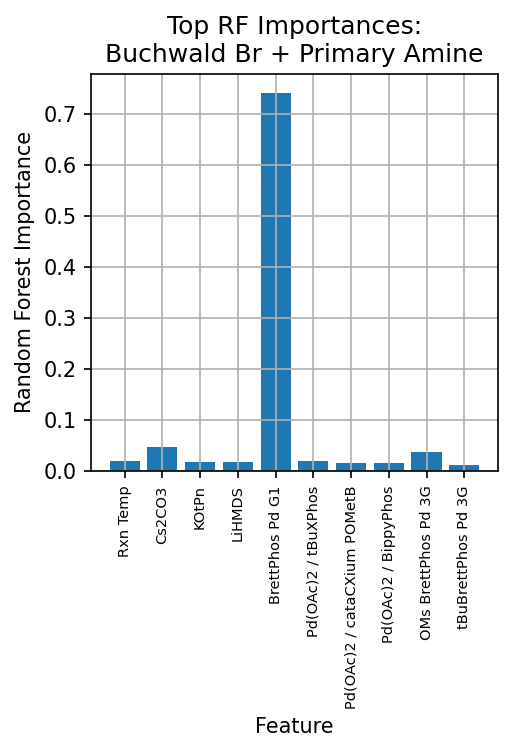

In [19]:
rf_imp_plot(r, feat_dict, 'Buchwald Br + Primary Amine')